# Fraud Detection Using Synthetic Financial Datasets

PaySim is a financial mobile money simulator devised for fraud detection. It is based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country.

Using this synthetic data, we aim to understand better all the features related to fraudulent profit by data analysis and make good predictions on the unseen data based on our findings.

Simulated transaction [data was downloaded from the Kaggle website](https://www.kaggle.com/ntnu-testimon/paysim1) and saved as .CSV file under the ‘data’ directory.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
sns.set_context(rc = {'patch.linewidth': 0.0})
sns.set_palette('Set2')

SMALL_SIZE = 13
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title\n",
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\n",
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title\n",
plt.rc('figure', dpi=160)

In [2]:
# Import data

paysim = pd.read_csv('../data/paysimdata.csv')
print(paysim.shape)
paysim.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Fields information

* step - integer - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - string/categorical - type of transaction: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - float - amount of the transaction in local currency.

* nameOrig - string - customer who initiated the transaction

* oldbalanceOrg - float initial balance before the transaction

* newbalanceOrig - float - new balance after the transaction

* nameDest - string - customer who is the recipient of the transaction

* oldbalanceDest - float - initial balance of recipient before the transaction.

* newbalanceDest - float - new balance of recipient after the transaction.

* isFraud - boolean/binary - tells if transaction is fraudulent (encoded as 1) or valid (encoded as 0)

* isFlaggedFraud - boolean/binary - tells if transaction is flagged as fraudulent (encoded as 1) or not flagged at all (encoded as 0). An observation is flagged if the transaction is fraudulent and it involved a transfer of over 200,000 in the local currency.

* Note: 
    The data includes an initial prediction on frauds in the ‘isFlaggedFraud’ column. 
    if a known fraudulent transaction amount > 200,000 in the local currency: flag = 1,
    else: flag = 0

# 1. EDA

In [3]:
# Summary statistics
paysim.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
#Check if there are any missing values
paysim.isnull().values.sum()

0

In [5]:
# Select only numerics columns to plot their distributions
paysim_numeric = paysim._get_numeric_data()
columns_to_plot = [col for col in paysim_numeric.columns if col not in ['isFraud', 'isFlagedFraud']]

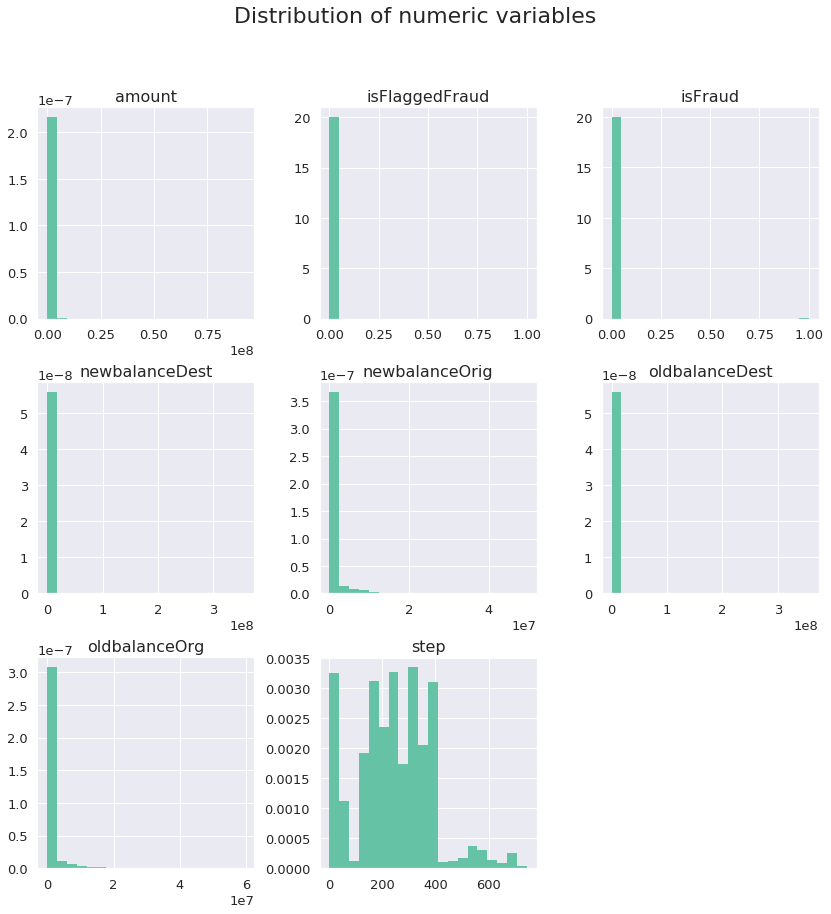

In [8]:
# Plot distribution of numeric variables
# Show and save the plot
paysim_numeric.hist(figsize=(14,14), density=True, bins=20)

# Set as a figure to export
fig1 = plt.gcf()
fig1.suptitle('Distribution of numeric variables', fontsize=22)

# Tick label format changed
plt.ticklabel_format(axis='x', style='plain')
plt.ticklabel_format(axis='y', style='plain')
plt.show()

# Figure saved
fig1.savefig('./Fig1.png', dpi=200)

Note: highly skewed distributions and none of these are normally distributed.

In [9]:
# Let's look at how many fraudulent transactions(= our target) are there 
# And compare if they were flagged as fraud or not

# Count 'isFraud'
counted_frauds = paysim['isFraud'].value_counts()
print('Raw counts of isFraud: ')
print(counted_frauds)
print('-'*30)
# Count 'isFlaggedFraud'
counted_flagged = paysim['isFlaggedFraud'].value_counts()
print('Raw counts of isFlaggedFraud: ')
print(counted_frauds)
print('-'*30)
# Normalize the 'isFraud' counts (=proportion of each label)
normalized_frauds = paysim['isFraud'].value_counts(normalize=True)
print('Normalized counts of isFraud: ')
print(normalized_frauds)
print('-'*30)
# Normalize the 'isFlaggedFraud' counts
normalized_flagged = paysim['isFlaggedFraud'].value_counts(normalize=True)
print('Normalized counts of isFlaggedFraud: ')
print(normalized_flagged)

Raw counts of isFraud: 
0    6354407
1       8213
Name: isFraud, dtype: int64
------------------------------
Raw counts of isFlaggedFraud: 
0    6354407
1       8213
Name: isFraud, dtype: int64
------------------------------
Normalized counts of isFraud: 
0    0.998709
1    0.001291
Name: isFraud, dtype: float64
------------------------------
Normalized counts of isFlaggedFraud: 
0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64


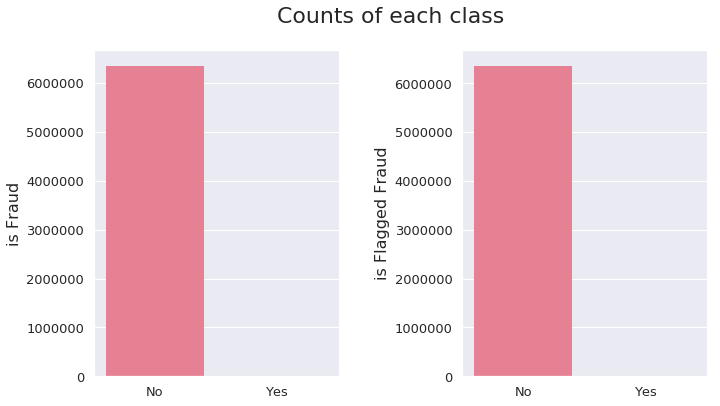

In [17]:
# Plot counted values of isFraud and isFlaggedFraud

fig2, ax = plt.subplots(1, 2, figsize=(11,6))
fig2.suptitle('Counts of each class', fontsize=22)
plt.subplots_adjust(wspace=.5)

ax0 = sns.barplot(x=['No', 'Yes'],
                  y=counted_frauds,
                  data=paysim,
                  palette='husl',
                  ax=ax[0])
ax1 = sns.barplot(x=['No', 'Yes'],
                  y=counted_flagged,
                  data=paysim,
                  palette='husl',
                  ax=ax[1])

ax0.set_ylabel('is Fraud', fontsize=16)
ax1.set_ylabel('is Flagged Fraud', fontsize=16)

# Show and save the plot
plt.show()
fig2.savefig('./Fig2.png', dpi=200)

Note: Both ‘isFraud’ and ‘isFlaggedFraud’ columns have extremely unbalanced distributions

This project deals with a classification problem where the goal is to predict highly
unbalanced binary class labels (0 and 1) of ‘isFraud’. To build our own prediction model, we
need to select our features-of-interest which provide a good forecast of our target, ‘isFraud’.

In [10]:
paysim.corr()['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

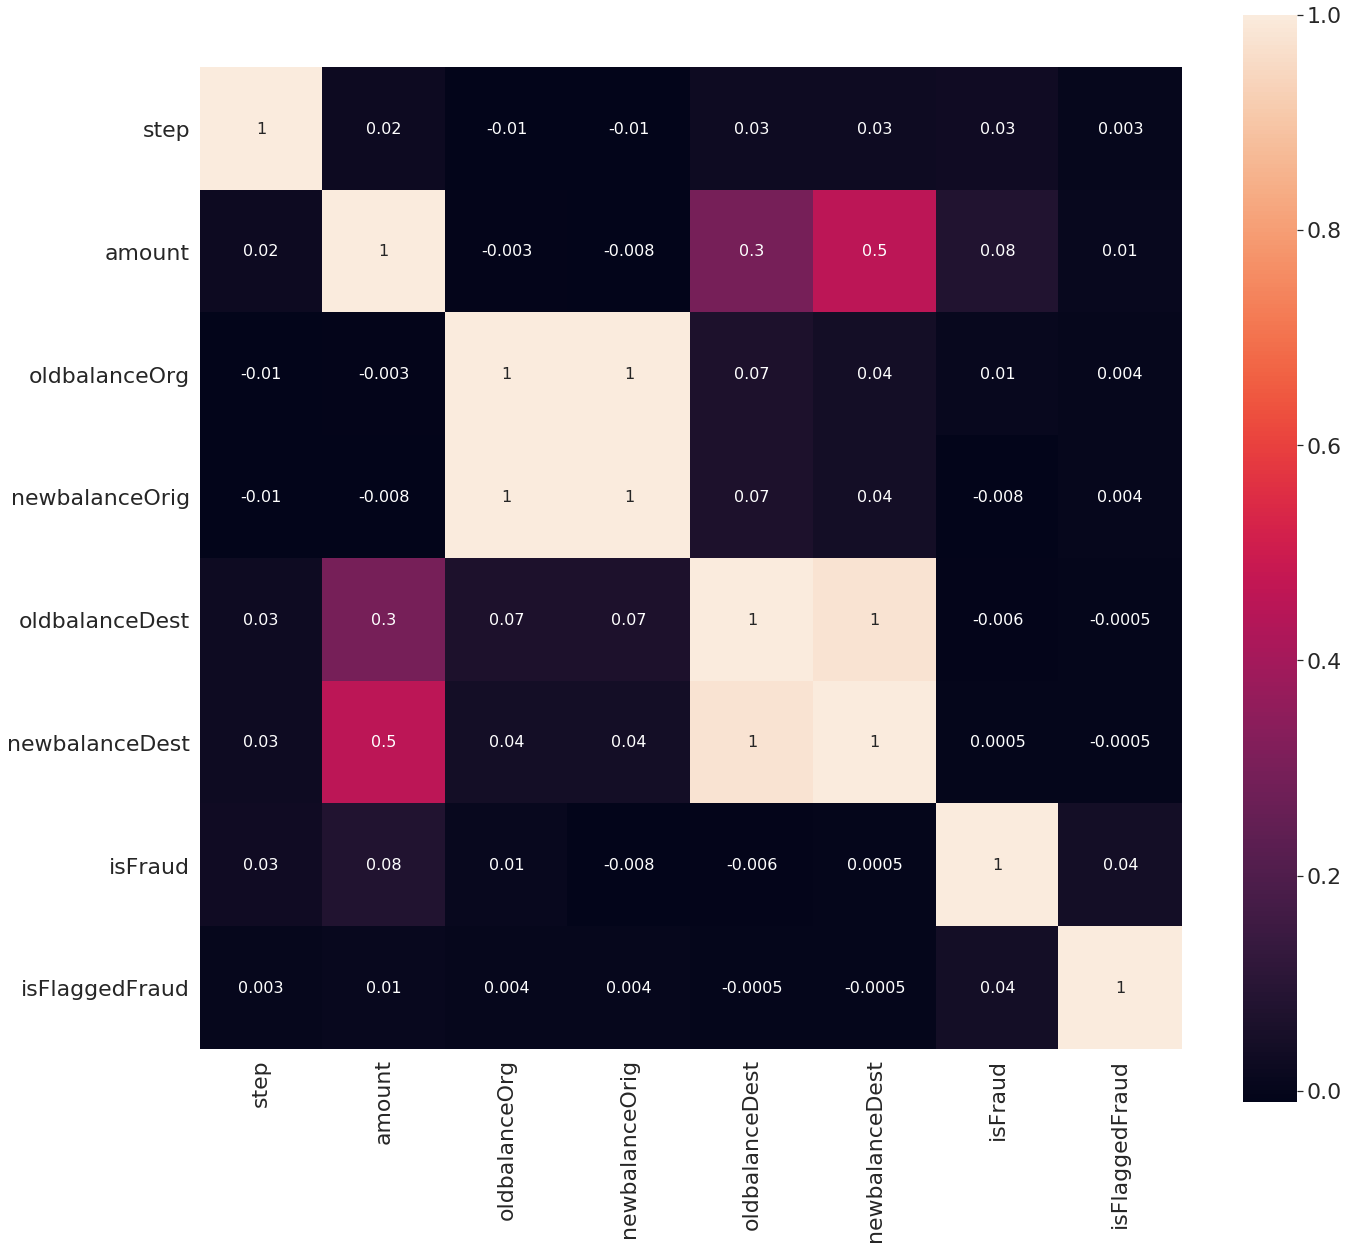

In [20]:
# Plot a correlation heatmap

fig3 = plt.figure(figsize=(22,20))
# fig3.suptitle('Correlation heatmap', fontsize=26)
sns.set(font_scale=2)
sns.heatmap(paysim.corr(), annot=True, fmt='.1g', square=True, annot_kws={"size": 16})
fig3.savefig('./Fig3.png', dpi=200)

Note:
Not possible to specify our scope to a few features using this metric, since
there were no columns having good correlation scores with the target (all measured values
were below |0.1|)

### Alternative way to understand the feature-target relationships:
By understanding the pattern of fraudulent transactions in the past, we can predict how the
future events will look like.

In [3]:
# Let's check TP, FP, TN, FN: proportion of each, how transactions look like in each case

is_fraud = paysim['isFraud']==1
is_flagged = paysim['isFlaggedFraud']==1

true_positive = paysim[is_fraud & is_flagged]
false_positive = paysim[~is_fraud & is_flagged]
true_negative = paysim[~is_fraud & ~is_flagged]
false_negative = paysim[is_fraud & ~is_flagged]

In [4]:
print(true_positive.shape)
print(false_positive.shape)
print(true_negative.shape)
print(false_negative.shape)

(16, 11)
(0, 11)
(6354407, 11)
(8197, 11)


**The current flagging system has failed on detecting >99% of frauds from this particular data (=low recall).**
<br>
**On the other hand, it successfully detects all the negative cases without any FPs (=high precision).**

### ● Recall:
* TP / (TP+FN)
* How many of the relevant issues are detected as relevant?

### ● Precision:
* TP / (TP+FP)
* How many events detected as relevant were actually relevant?

One of the most probable reasons for this low recall is the high imbalance observed from
the target class distribution. Thus, we can expect to enhance our forcast by reducing FNs
and improving the recall score. To do so, we looked into characteristics of features in two
datasets, TP and FN, and compared.

CASH_OUT    0.35
PAYMENT     0.34
CASH_IN     0.22
TRANSFER    0.08
DEBIT       0.01
Name: type, dtype: float64


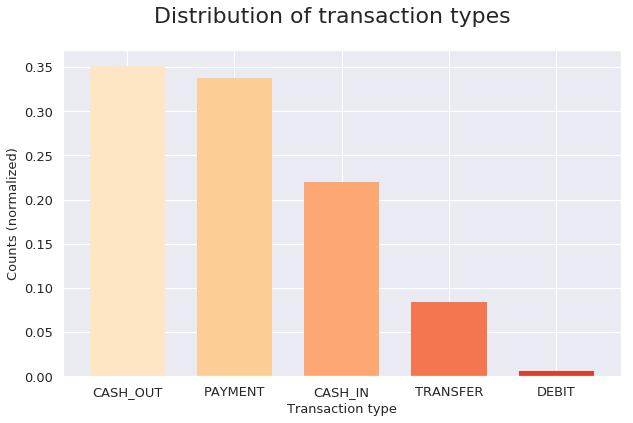

In [50]:
# Visualize different types of transactions
fig4 = plt.gcf()
fig4.suptitle('Distribution of transaction types', fontsize=22)
print(round(paysim.type.value_counts(normalize=True),2))
paysim.type.value_counts(normalize=True).plot(kind='bar',
                                              figsize=(10,6),
                                              width=.7,
                                              color=sns.color_palette("OrRd"))

plt.xticks(rotation=0)
plt.ylabel('Counts (normalized)')
plt.xlabel('Transaction type')
plt.show()
fig4.savefig('./Fig4.png', dpi=200)

### 1-1. Take a look at the characteristics of the detected frauds (TP)

In [51]:
print(f'Transaction type(s) detected in fraud cases: {true_positive.type.unique()}')

Transaction type(s) detected in fraud cases: ['TRANSFER']


In [52]:
# A function to look for names appeared in any fraudulent transaction

def get_names_with_false_amount(data):
    Difference_Orig = data['oldbalanceOrg'] - data['newbalanceOrig']
    Difference_Dest = data['oldbalanceDest'] - data['newbalanceDest']

    # If transaction amount is not equal to the difference in balances of origin
    suspicious_names = []
    if (data['amount'] != Difference_Orig).any():
        suspicious_names += [name for name in data.nameOrig if name not in suspicious_names]
        suspicious_names += [name for name in data.nameDest if name not in suspicious_names]
    print(f'Fraud alert!!!')
    return list(set(suspicious_names))


In [53]:
suspicious_names = get_names_with_false_amount(true_positive)
suspicious_names

Fraud alert!!!


['C1035541766',
 'C1861208726',
 'C1109166882',
 'C1392803603',
 'C1100697970',
 'C2140038573',
 'C661958277',
 'C908544136',
 'C786455622',
 'C728984460',
 'C193696150',
 'C1869569059',
 'C1082139865',
 'C891140444',
 'C1892216157',
 'C724693370',
 'C1100582606',
 'C452586515',
 'C1806199534',
 'C1770418982',
 'C1684585475',
 'C639921569',
 'C1308068787',
 'C1366804249',
 'C992223106',
 'C689608084',
 'C19004745',
 'C484597480',
 'C917414431',
 'C1147517658',
 'C1909486199',
 'C1395467927']

In [54]:
# A function to detect any transaction activities in which appeared these suspicious_names

def suspicious_transactions_by_name(data, names_list):
    suspicious_records = pd.DataFrame()
    for name in names_list:
        name_matched = data[(data['nameOrig']==name) | (data['nameDest']==name)]
        if (name_matched['isFraud']==1).any():
            suspicious_records = suspicious_records.append(name_matched)
    return suspicious_records

In [55]:
# Did the names used in detected frauds used in other undetected frauds?

suspicious_names_records = suspicious_transactions_by_name(false_negative, suspicious_names)
print(suspicious_names_records.shape)
suspicious_names_records

(0, 0)


""


No, the names detected in TPs were not used in other fraudulent transactions.<br>


### 1-2.  Check the false negatives and figure out why they were not detected

Typical transaction type(s) in flagged cases: ['TRANSFER' 'CASH_OUT']


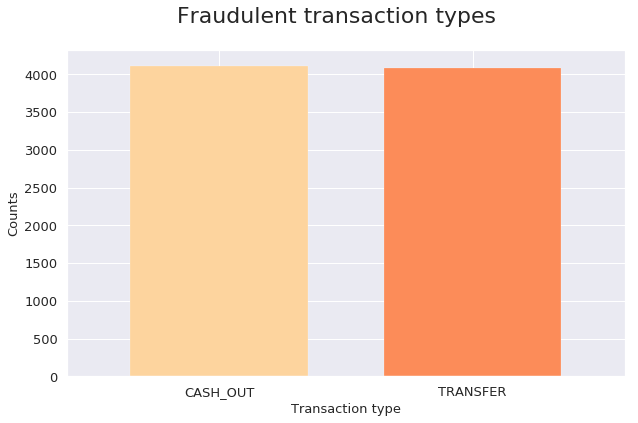

In [61]:
# What are the main transaction types of FNs?
print(f'Typical transaction type(s) in flagged cases: {false_negative.type.unique()}')

# Plot and save it as a figure
false_negative.type.value_counts().plot(kind='bar',
                                        figsize=(10,6),
                                        color=sns.color_palette('OrRd',3),
                                        width=.7)

fig5 = plt.gcf()
fig5.suptitle('Fraudulent transaction types', fontsize=22)
plt.xticks(rotation=0)
plt.ylabel('Counts')
plt.xlabel('Transaction type')
plt.show()
fig5.savefig('./Fig5.png', dpi=200)

It makes sense that the most of fraudulent actions are 'Transfer' or 'cash out', and not, for example, 'cash in'. Thus we can create a new column to flag when a transaction was either 'Transfer' or 'Cash out'

# 2. Feature selection

### 2-1. Balance-related columns

Let's see if information on balances before & after transactions can be an indicator for a fraud behavior.

In [5]:
df_list = [true_positive, false_negative, true_negative]
df_names = ['true_positive', 'false_negative', 'true_negative']
balances = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

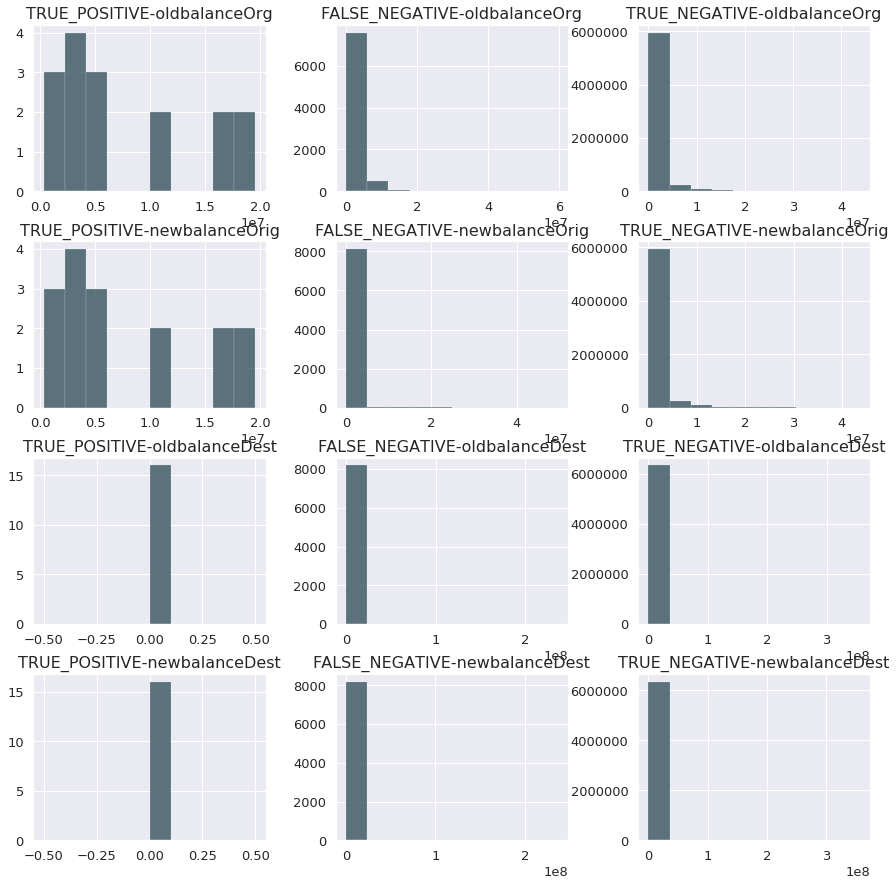

In [62]:
# Let's compare balance of customer and recipient before & after transaction
# (TP vs. FN vs. TN)
sns.set_context(rc = {'patch.linewidth': 0.2})
sns.set_palette('GnBu_d')

fig6, ax = plt.subplots(4, 3, figsize=(15,15))
plt.subplots_adjust(hspace=.3, wspace=.3)

for i, df in enumerate(df_list):
    for j, balance in enumerate(balances):
        g=df[balance].hist(alpha=.8, ax=ax[j, i%3])
        g.set_title(df_names[i].upper()+'-'+balances[j])
        
plt.show()
fig6.savefig('./Fig6.png', dpi=240)

Note:<br>
- Note that the y-axis are not uniform.
- 'Balance' columns can be a confounding feature since false_negatives have similar distribution of the values with true_negatives, rather than with true positives.
Therefore, these features can be excluded for the future modeling.

### 2-2. Transaction amount


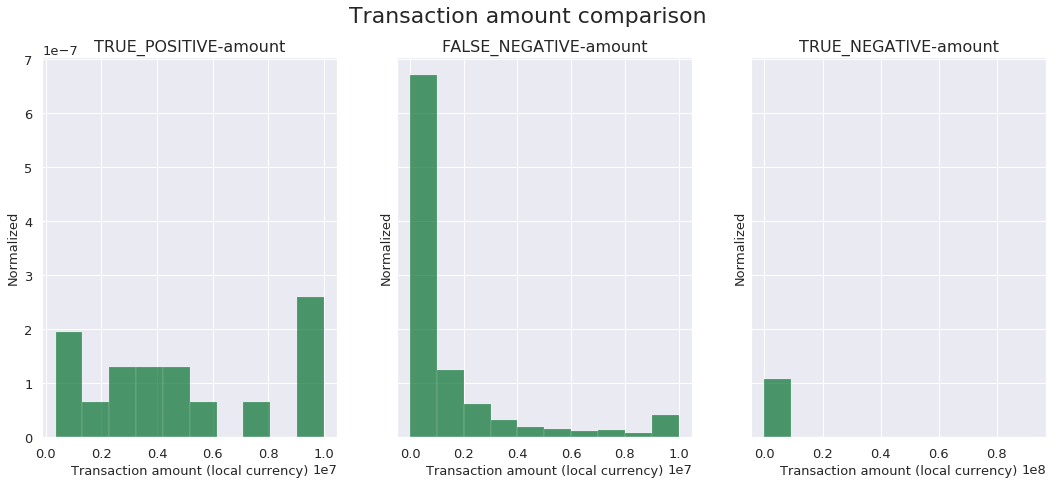

In [86]:
# Plot amount of each transaction (TP vs. FN vs. TN)

# Set color and figure
sns.set_palette('BuGn_r')
fig7, ax = plt.subplots(1, 3, figsize=(18,7), sharey=True)
fig7.suptitle('Transaction amount comparison', fontsize=22)

plt.subplots_adjust(wspace=.2, hspace=.6)
for a in ax:
    a.set_xlabel('Transaction amount (local currency)')
    a.set_ylabel('Normalized')

for i, df in enumerate(df_list):
    g = df.amount.hist(alpha=.7, ax=ax[i], density=True) #Normalized histogram
    g.set_title(df_names[i].upper()+'-amount')
    g.ticklabel_format(style = 'sci')
    


plt.show()
fig7.savefig('./Fig7.png', dpi=200)

Note:<br>
- In TNs, there were barely any events that surpassed 200,000 of amounts in transaction, whereas fraudulent activities involved more varied amounts of money mobilization.
- We did not perform the one-way ANOVA, a parametric test for statistical differences among 3 or more groups, on this set of data due the huge difference in sample size and internal variance of the groups.

### 2-3. Time (step) of transactions

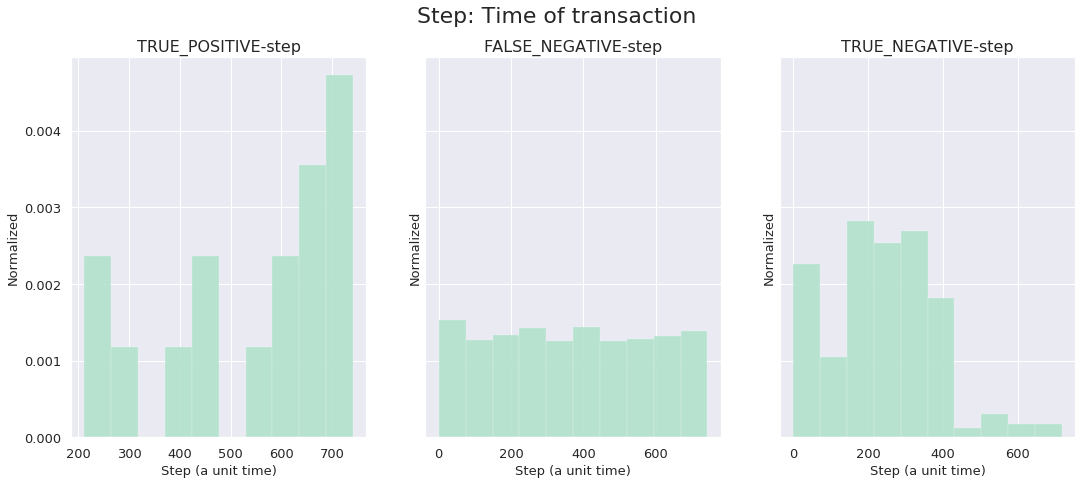

In [102]:
# Steps: a unit of time: 1 step is 1 hour of time. Total steps 744 (30 days simulation).
sns.set_palette('Pastel2')
fig8, ax = plt.subplots(1, 3, figsize=(18,7), sharey=True)
fig8.suptitle('Step: Time of transaction', fontsize=22)

plt.subplots_adjust(wspace=.2, hspace=.6)
for a in ax:
    a.set_xlabel('Step (a unit time)')
    a.set_ylabel('Normalized')

for i, df in enumerate(df_list):
    g = df.step.hist(alpha=.9, ax=ax[i], density=True) #Normalized histogram
    g.set_title(df_names[i].upper()+'-step')


    
plt.show()
fig8.savefig('./Fig8.png', dpi=200)

Note:
- There are more fraudulent activities when step > 400
- Unlike TNs, FNs were seen regularly over the steps without large variance.
- In TN cases, the transaction activity decreases after the first half of the simulation steps.

### 2-4. Name of clients and recipients

From de nameOrig and nameDest columns, the input that starts with 'C' is the Customer and if starts with 'M' is the Business.<br>
So let's count the transactions by customer-recipient type: (CC,CB,BC,BB)

In [23]:
# Add feature validTransactionType to the new df
paysim_new = paysim.copy()
paysim_new["validTransactionType"] = np.nan # Initialize a new feature column: ‘validTransactionType’

In [24]:
# Assign new categorical (nominal) values according to its corresponding transaction type
paysim_new.loc[paysim.nameOrig.str.startswith('C') & paysim.nameDest.str.startswith('C'),"validTransactionType"] = "CC" 
paysim_new.loc[paysim.nameOrig.str.startswith('C') & paysim.nameDest.str.startswith('M'),"validTransactionType"] = "CB"
paysim_new.loc[paysim.nameOrig.str.startswith('M') & paysim.nameDest.str.startswith('C'),"validTransactionType"] = "BC"
paysim_new.loc[paysim.nameOrig.str.startswith('M') & paysim.nameDest.str.startswith('M'),"validTransactionType"] = "BB"

# Print out the result dataframe
paysim_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,validTransactionType
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,CB
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,CB
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,CC
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,CC
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,CB


In [25]:
# 'is_fraud' mask created previously
fraud_df = paysim_new[is_fraud]
valid_df = paysim_new[~is_fraud]

# The counts of transactions by customer-recipient type (CC,CB,BC,BB)
print("Fraud transactions and customer-recipient type: \n",fraud_df.validTransactionType.value_counts())
print()
print("Valid transactions and customer-recipient type: \n",valid_df.validTransactionType.value_counts())

Fraud transactions and customer-recipient type: 
 CC    8213
Name: validTransactionType, dtype: int64

Valid transactions and customer-recipient type: 
 CC    4202912
CB    2151495
Name: validTransactionType, dtype: int64


Note: All fraud transactions were 'CC' type

# 3. Final features and target

In [26]:
# Previously, we defined a new dataframe with some newly introduced features
paysim_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
step                    int64
type                    object
amount                  float64
nameOrig                object
oldbalanceOrg           float64
newbalanceOrig          float64
nameDest                object
oldbalanceDest          float64
newbalanceDest          float64
isFraud                 int64
isFlaggedFraud          int64
validTransactionType    object
dtypes: float64(5), int64(3), object(4)
memory usage: 582.5+ MB


In the next step, we'll implement different machine learning algorithms to enhance the detection rate of fraud activity with this feature engineered dataset. Since our target is a binary column ('isFraud'), we're dealing with a classification problem.

For our modeling, we'll export this dataframe as a csv file.

In [27]:
paysim_new.to_csv("../data/paysim_for_ML.csv")

In [ ]:
# Sanity check
paysim_for_ML = pd.read_csv("../data/paysim_for_ML.csv", index_col=0)

print(paysim_for_ML.shape)
paysim_for_ML.head()